In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import astropy
import pickle as p
import glob
from matplotlib.colors import LogNorm,SymLogNorm,Normalize

In [28]:
import matplotlib.pyplot as plt
# Figure
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox']='tight'

# Font
plt.rcParams['font.size']=20
plt.rcParams['font.weight'] = 300

# Axes
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.width']=2
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.major.size']=5

# Line
plt.rcParams['lines.linewidth']=2

# Image
plt.rcParams['image.origin']='lower'

In [29]:
def potential(z0):
    import astropy.constants as c
    import astropy.units as u
    
    sig_star=42*c.M_sun/c.pc**2
    rho_dm=6.4e-3*c.M_sun/c.pc**3
    R0=8.e3*c.pc
    zstar=245*c.pc
    
    z   = z0 * c.pc
    phi = 2.*np.pi*c.G*sig_star*zstar*((1.+(z/zstar)**2.)**0.5 -1.) + 2*np.pi*c.G*rho_dm*R0*R0*np.log(1+(z/R0)**2.)
    return phi.to('km^2/s^2')

In [30]:
def get_ballistic(pdf0,zf,zmax=3584.,zini=1000.):
    vz=pdf0.vz
    dv_phi2=2.0*(potential(zf)-potential(zini))
    dv_cut=np.sqrt(2.0*(potential(zmax)-potential(zini))).value
    dv_phi=np.sqrt(dv_phi2.value)
    pidx=(vz>dv_phi)
    pvf=np.sqrt(vz**2-dv_phi**2)[pidx]
    nidx=(vz>dv_phi) & (vz < dv_cut)
    nvf=-np.sqrt(vz**2-dv_phi**2)[nidx]
    vf=np.concatenate([np.array(nvf)[::-1],np.array(pvf)])
    pdf_vf=np.concatenate([np.array(pdf0.interp(vz=nvf.vz))[::-1],np.array(pdf0.interp(vz=pvf.vz))])
    return vf,pdf_vf

In [31]:
from matplotlib.ticker import MultipleLocator
def toggle_xticks(axes,visible=False):
    plt.setp([ax.get_xticklabels() for ax in axes],visible=visible)
def toggle_yticks(axes,visible=False):
    plt.setp([ax.get_yticklabels() for ax in axes],visible=visible)

In [32]:
base='../data/'

In [33]:
mean_pdf=[]
for phase in ['warm','int','hot']:
    with xr.open_dataarray('{}/mpdf_{}.nc'.format(base,phase)) as da:
        da.load()
    mean_pdf.append(da.mean(dim='time'))
mean_pdf.append(mean_pdf[1]+mean_pdf[0].interp(vz=mean_pdf[1].vz).fillna(0.)*2.5)

/Users/ckim/miniconda3/lib/python3.7/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/Users/ckim/miniconda3/lib/python3.7/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/Users/ckim/miniconda3/lib/python3.7/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


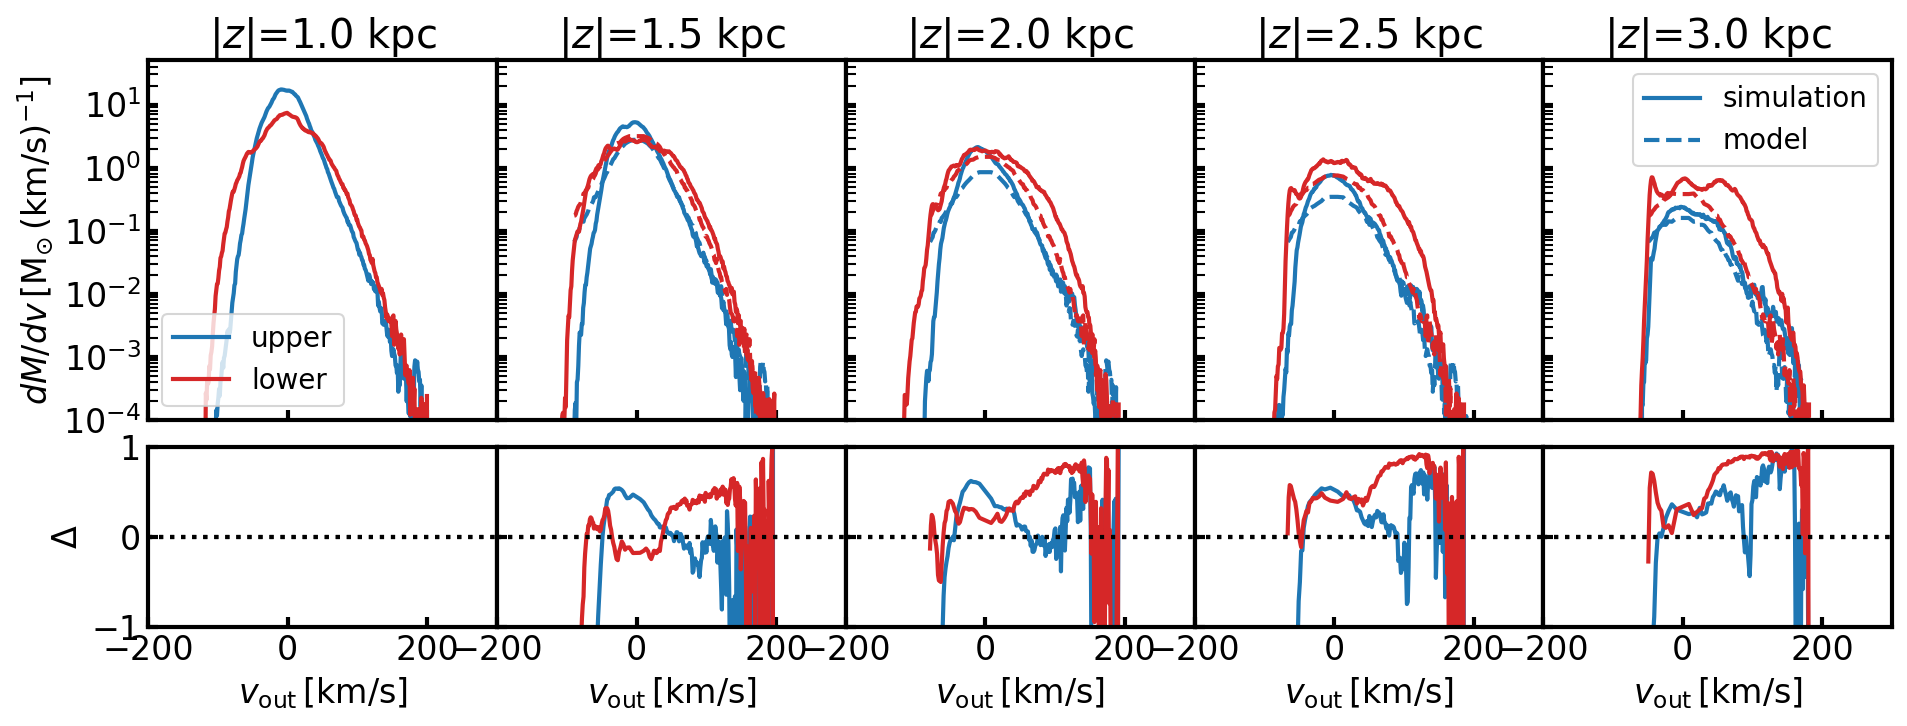

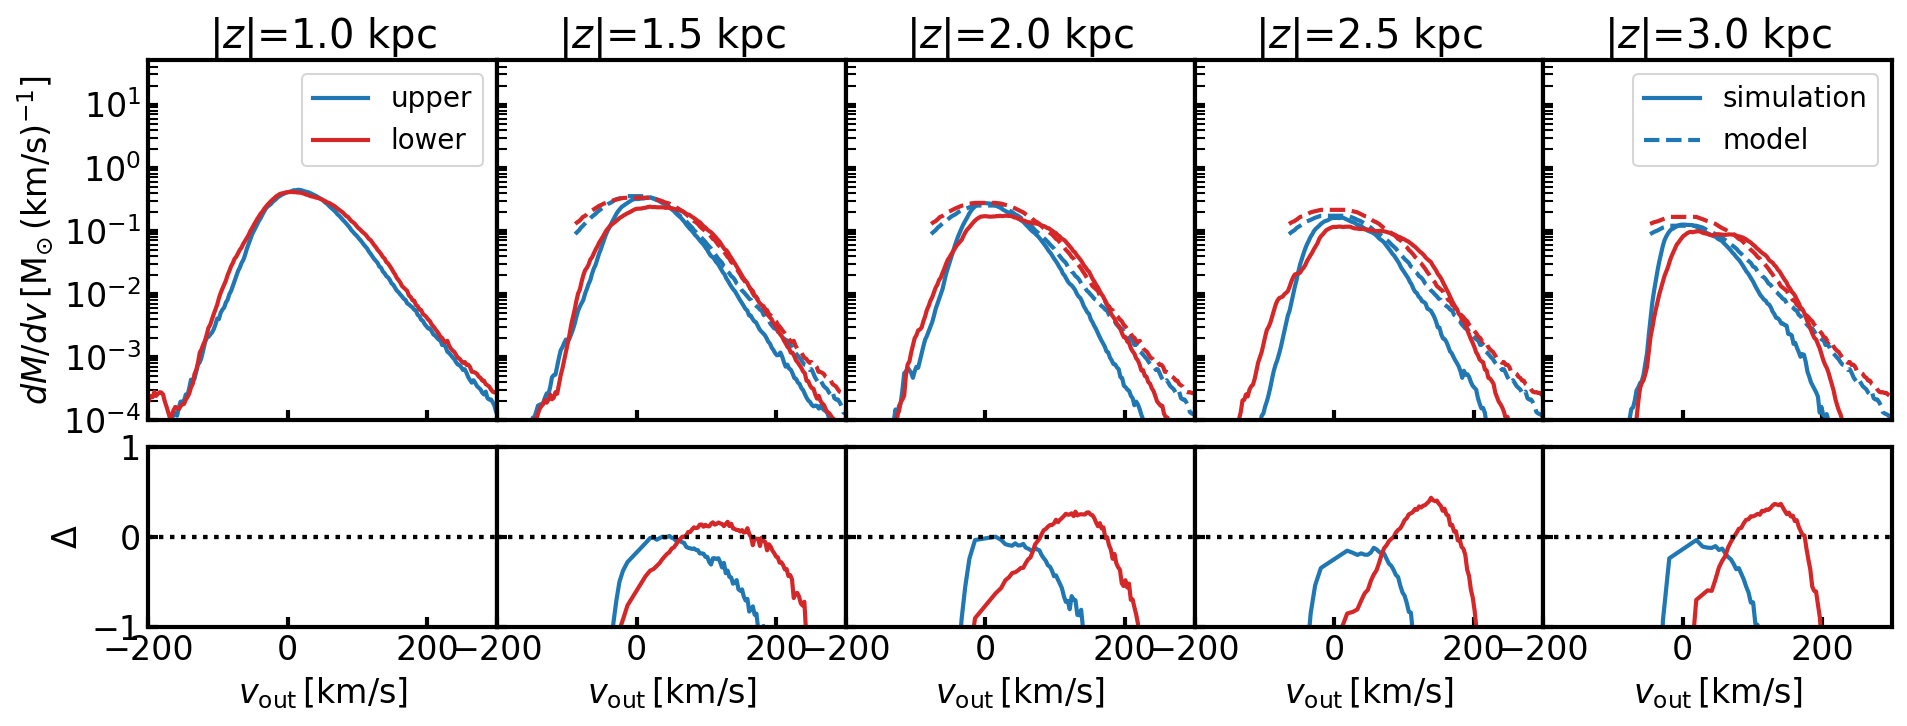

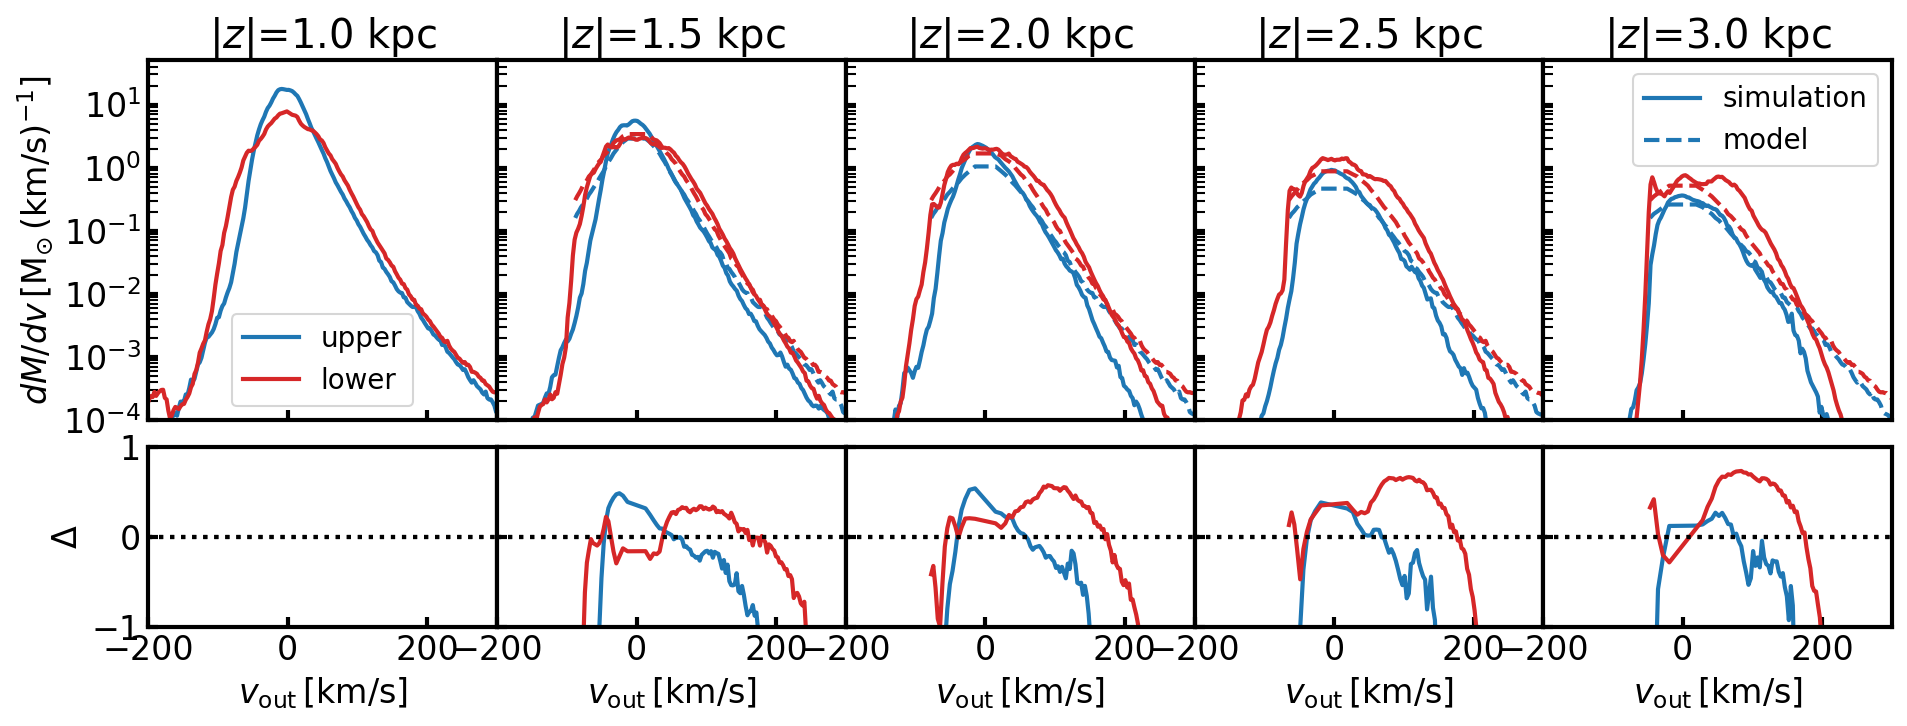

In [37]:
plt.rcParams['font.size']=16
zini=1000.
zmax=3584.
z0=[1000.,1500.,2000.,2500.,3000.]
dz=10.
for ipdf,phase_,let_,xlims_ in zip([0,1,3],['warm','int','warm_int'],'abc',
                                        [(-200,300),(-200,300),(-200,300)]):
    mpdf_mean=mean_pdf[ipdf]
    fig,axes=plt.subplots(2,len(z0),sharex=True,
                          gridspec_kw={'wspace':0,'hspace':0.1,'height_ratios':[2,1]},figsize=(15,5))
    dv=mpdf_mean.vz[1]-mpdf_mean.vz[0]

    for sign,lab_,color_ in zip([1.0,-1.0],['upper','lower'],['C0','C3']):
        for z0_,ax1,ax2 in zip(z0,axes[0,:],axes[1,:]):
            zmean=mpdf_mean.interp(z=z0_*sign,vz=mpdf_mean.vz*sign)
            pdf=xr.DataArray(zmean,coords=[mpdf_mean.vz])/dv
            l,=ax1.plot(pdf.vz,pdf,label=lab_,color=color_)
            ax1.set_title(r'$|z|$={:3.1f} kpc'.format(z0_/1.e3))
            if z0_>zini: 
                vf,pdf_vf=get_ballistic(pdf0,z0_,zmax=zmax,zini=zini)
                ax1.plot(vf,pdf_vf,color=l.get_color(),ls='--')
                sim=pdf.interp(vz=vf)
                diff=(sim-pdf_vf)/sim
                ax2.plot(vf,diff,color=color_)
            else:
                pdf0=pdf
            ax1.set_yscale('log')
            ax1.set_xlim(xlims_)
            ax1.set_ylim(1.e-4,5.e1)
            ax2.axhline(0,ls=':',color='k')
            ax2.set_ylim(-1,1)
            #ax2.set_xticks([-50,0,50,150])
    ax=axes[0,0]
    ax.set_ylabel(r'$dM/dv\,[{\rm M_{\odot}\,(km/s)^{-1}}]$')
    ax.legend(fontsize='small')
    #ax.text(-0.25,1.1,'({})'.format(let_),transform=ax.transAxes,fontsize=20)

    lines=axes[0,-1].lines
    axes[0,-1].legend(lines[:2],['simulation','model'],fontsize='small')
    axes[1,0].set_ylabel(r'$\Delta$')
    toggle_yticks(axes[:,1:].flat)
    for ax in axes[1,:]:
        ax.set_xlabel(r'$v_{\rm out}\,[{\rm km/s}]$')
    fig.savefig('../figures/ballistic_{}.pdf'.format(phase_),dpi=150,bbox_inches='tight')

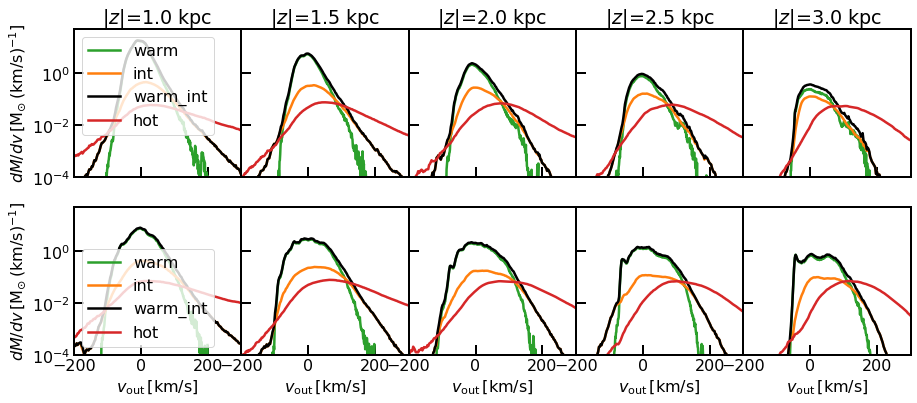

In [27]:
plt.rcParams['font.size']=16
zini=1000.
zmax=3584.
z0=[1000.,1500.,2000.,2500.,3000.]
dz=10.
fig,axes=plt.subplots(2,len(z0),sharex=True,
                      gridspec_kw={'wspace':0},figsize=(15,6))
for sign,lab_,axes_ in zip([1.0,-1.0],['upper','lower'],[axes[0,:],axes[1,:]]):

    
    for ipdf,phase_,let_,color_,xlims_ in zip([0,1,3,2],['warm','int','warm_int','hot'],'abcd',
                                       ['C2','C1','k','C3'],
                                        [(-200,300),(-200,300),(-200,300),(-200,300)]):
        mpdf_mean=mean_pdf[ipdf]
        dv=mpdf_mean.vz[1]-mpdf_mean.vz[0]

        for z0_,ax1 in zip(z0,axes_):

            zmean=mpdf_mean.interp(z=z0_*sign,vz=mpdf_mean.vz*sign)
            pdf=xr.DataArray(zmean,coords=[mpdf_mean.vz])/dv
            l,=ax1.plot(pdf.vz,pdf,label=phase_,color=color_)
            if sign == 1.0: ax1.set_title(r'$|z|$={:3.1f} kpc'.format(z0_/1.e3))
#             if z0_>zini: 
#                 vf,pdf_vf=get_ballistic(pdf0,z0_,zmax=zmax,zini=zini)
#                 ax1.plot(vf,pdf_vf,color=l.get_color(),ls='--')
#                 sim=pdf.interp(vz=vf)
#                 diff=(sim-pdf_vf)/sim
#                 ax2.plot(vf,diff)
#             else:
#                 pdf0=pdf
            ax1.set_yscale('log')
            ax1.set_xlim(xlims_)
            ax1.set_ylim(1.e-4,5.e1)
    ax=axes_[0]
    ax.set_ylabel(r'$dM/dv\,[{\rm M_{\odot}\,(km/s)^{-1}}]$')
    ax.legend()
#    ax.text(-0.25,1.1,'({})'.format(let_),transform=ax.transAxes,fontsize=20)

    toggle_yticks(axes_[1:].flat)   
for ax in axes[1,:]:
    ax.set_xlabel(r'$v_{\rm out}\,[{\rm km/s}]$')
    fig.savefig('../supplement/vpdf_all.pdf',dpi=150,bbox_inches='tight')

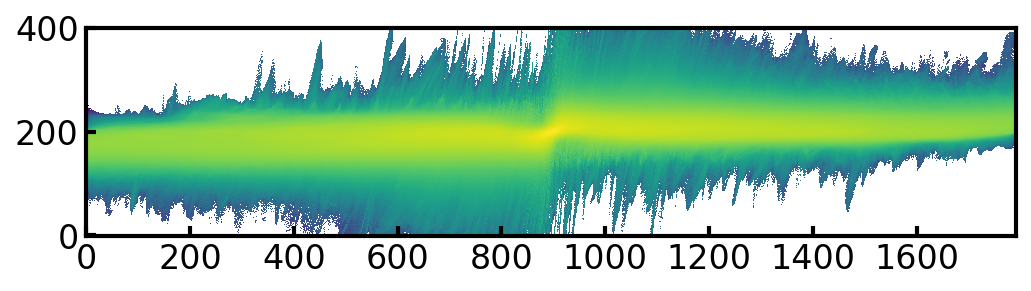

In [43]:
plt.imshow(mean_pdf[1],norm=LogNorm())